**Objective:**  : to learn how machine learning tools and algorithms (scikit-learn, XGBoost, LightGBM) work in practice by predicting the age of abalone.

**Data:** 
Abalone Data Set ([web link](https://archive.ics.uci.edu/ml/datasets/abalone)).    
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [[source]](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.

**Features:**
* Sex - M, F, I (infant)
* Length - the longest shell measurement (mm)
* Diameter - perpendicular to length (mm) 
* Height - with meat in shell (mm) 
* Whole_weight - whole abalone (grams) 
* Shucked_weight  - weight of meat (grams) 
* Viscera_weight - gut weight (after bleeding) (grams) 
* Shell_weight - after being dried (grams) 
* Rings - +1.5 gives the age in years

## 1. Setup

In [ ]:
# Load modules for dataset analysis
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Load modules for machine learning
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import FunctionTransformer, StandardScaler, Normalizer, PolynomialFeatures
from sklearn.decomposition import PCA, FastICA, FactorAnalysis
from sklearn.kernel_approximation import Nystroem, AdditiveChi2Sampler

from sklearn.model_selection import GridSearchCV, validation_curve

from sklearn.metrics import mean_absolute_error, f1_score

In [ ]:
# Load modules for regression task
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# Load modules for classification task
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import xgboost as xgb
import lightgbm as lgb

## 2. Data exploration

In [ ]:
# Load data into a pandas DataFrame to work with
abalone_data = pd.read_csv('Data/abalone.data', header=None)
# Assign names to the columns
abalone_data.columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
                        'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']

In [ ]:
# Check if the data size is as described in the source
abalone_data.shape

(4177, 9)

In [ ]:
# Look at data
abalone_data.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


The data description says that the ranges of continuous values have been scaled by dividing by 200.

In [ ]:
# Split data into train and test
abalone_train_all, abalone_test_all = train_test_split(
    abalone_data, test_size=0.2, random_state=0)

We have divided the dataset into test and training data. Next, we will continue to work and change only the training data, and when we talk about the dataset, we will keep this part in mind. We will need the test data at the end to test how the model we will eventually choose works.

### 2.1. Overview of the training dataset

In [ ]:
abalone_train_all.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
3141,I,0.180,0.135,0.080,0.0330,0.0145,0.0070,0.0100,5
3521,I,0.215,0.150,0.055,0.0410,0.0150,0.0090,0.0125,3
883,M,0.660,0.530,0.170,1.3905,0.5905,0.2120,0.4530,15
3627,M,0.715,0.525,0.200,1.8900,0.9500,0.4360,0.4305,10
2106,M,0.595,0.455,0.155,1.0410,0.4160,0.2105,0.3650,14


In [ ]:
# Check the data for duplicate rows
abalone_train_all.duplicated().sum()

0

In [ ]:
# View the size of the training data
abalone_train_all.shape

(3341, 9)

Now we can start exploring the features. First, we will look at each of them individually, and then the relationships between them. To do this, we will determine which columns of our DataFrame are numeric and which contain objects.

In [ ]:
# View a data type of columns
abalone_train_all.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole_weight      float64
Shucked_weight    float64
Viscera_weight    float64
Shell_weight      float64
Rings               int64
dtype: object

To build the model, we need all inputs to be numeric. In our dataset, only one column is not - "Sex".

### 2.2. Analysis of column values ​​in the dataset

First, we will look at statistics for columns with the object data type and ranges (maximum and minimum) of features values and target with the numeric data type.

In [ ]:
# Output statistics for objects
abalone_train_all.describe(include=[np.object])

,Sex
count,3341
unique,3
top,M
freq,1232


Statistics show that most of the set of individuals is male. 

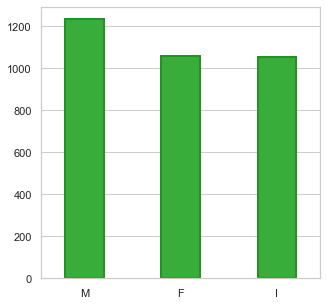

In [ ]:
sns.set_theme(style='whitegrid')
fig1, axs1 = plt.subplots(figsize=(5, 5))

# Draw bars to show the frequency of the abalone by sex
abalone_train_all['Sex'].value_counts().plot.bar(ax=axs1, color='#39ad39', edgecolor='#249124',
                                                 linewidth=2, width=0.4, rot=0)
axs1.xaxis.grid(False)
plt.show()

The bars show that there is a slight class imbalance in general.

In [ ]:
abalone_train_all.max(axis=0)

Sex                    M
Length             0.815
Diameter            0.65
Height              1.13
Whole_weight      2.7795
Shucked_weight     1.488
Viscera_weight      0.76
Shell_weight       1.005
Rings                 27
dtype: object

In [ ]:
abalone_train_all.min(axis=0)

Sex                    F
Length             0.075
Diameter           0.055
Height                 0
Whole_weight       0.002
Shucked_weight     0.001
Viscera_weight    0.0005
Shell_weight      0.0015
Rings                  1
dtype: object

As we can see, the minimum height value is zero. This value may have occurred due to rounding after scaling, or it indicates a missing value. If the number of such values is small, then we will remove such rows.

In [ ]:
abalone_train_all[abalone_train_all.Height == 0]

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


In [ ]:
# Remove rows with a height value of 0
abalone_train_all_0 = abalone_train_all.drop(index=[1257, 3996])

Logically, the whole weight of an abalone should be greater than the sum of its meat, viscera, and shell. And also the weight of each of them should be less than the whole weight. We will check if there are any relevant errors in the data and remove them. 

In [ ]:
# Compare the whole weight with the sum of its components
abalone_train_1 = abalone_train_all_0.loc[abalone_train_all_0['Whole_weight'] < (abalone_train_all_0['Shucked_weight']
                                                                                 + abalone_train_all_0['Viscera_weight']
                                                                                 + abalone_train_all_0['Shell_weight'])]
print('Whole weight < (Shucked weight + Viscera weight + Shell weight): \n\n',
      abalone_train_1.loc[:, 'Whole_weight':'Shell_weight'])

Whole weight < (Shucked weight + Viscera weight + Shell weight): 

       Whole_weight  Shucked_weight  Viscera_weight  Shell_weight
3875        0.1385          0.0480          0.0460        0.0500
2329        0.5825          0.2315          0.1210        0.2550
3601        0.2260          0.1135          0.0515        0.0675
3034        0.6855          0.2930          0.1630        0.3800
317         0.3675          0.1465          0.1015        0.1200
...            ...             ...             ...           ...
2854        1.3850          0.8875          0.3095        0.4050
3115        0.4995          0.2965          0.0945        0.1185
2171        0.0295          0.0155          0.0150        0.0100
2146        0.5205          0.2015          0.1625        0.1850
2292        0.3215          0.1545          0.0750        0.0950

[124 rows x 4 columns]


In [ ]:
# Сompare the whole weight with the weight of each part of it
abalone_train_2 = abalone_train_all_0.loc[
    (abalone_train_all_0['Whole_weight'] < abalone_train_all_0['Shucked_weight'])
    | (abalone_train_all_0['Whole_weight'] < abalone_train_all_0['Viscera_weight']) 
    | (abalone_train_all_0['Whole_weight'] < abalone_train_all_0['Shell_weight'])]
print('Whole weight < (Shucked weight or Viscera weight or Shell weight): \n\n', 
abalone_train_2.loc[:, 'Whole_weight':'Shell_weight'])

Whole weight < (Shucked weight or Viscera weight or Shell weight): 

       Whole_weight  Shucked_weight  Viscera_weight  Shell_weight
1216        0.1055          0.4350          0.0150         0.040
2641        0.1315          0.2025          0.0875         0.123


We can see that 126 rows have errors in the weight data. They may have occurred due to a rounding error or due to scaling.

In [ ]:
# Remove rows with invalid weight values
drop_indexes = set(abalone_train_1.index.to_list() + abalone_train_2.index.to_list())
abalone_train_0 = abalone_train_all_0.drop(index=list(drop_indexes))

In [ ]:
# Output statistics for numeric columns
abalone_train_0.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,3215.000000,3215.000000,3215.000000,3215.000000,3215.000000,3215.000000,3215.000000,3215.000000
mean,0.529103,0.412005,0.141056,0.850230,0.367391,0.184347,0.244008,10.029549
std,0.117678,0.097274,0.042206,0.491906,0.222580,0.110043,0.139345,3.205092
min,0.110000,0.090000,0.015000,0.008000,0.002500,0.000500,0.003000,2.000000
25%,0.455000,0.350000,0.115000,0.456500,0.191500,0.096000,0.135000,8.000000
50%,0.550000,0.430000,0.145000,0.826000,0.347000,0.174000,0.239000,10.000000
75%,0.620000,0.485000,0.170000,1.177500,0.512500,0.256750,0.331500,11.000000
max,0.815000,0.650000,1.130000,2.779500,1.488000,0.760000,1.005000,27.000000


As we can see from the statistics above, the training dataset does not contain missing values and the values of the whole weight of the abalone fluctuate the most. We will visualize these statistics.

In [ ]:
num_cols = [col for col in abalone_train_0.select_dtypes(include='number').columns]

In [ ]:
# Divide the attributes into three groups according to the scale of values
att_largest_scale = []
att_large_scale = []
att_small_scale = []

scale_bounds = (2, 20)

for col in num_cols:
    scale = abalone_train_0[col].max() - abalone_train_0[col].min()

    if scale > scale_bounds[0]:
        if scale > scale_bounds[1]:
            att_largest_scale.append(col)
        else:
            att_large_scale.append(col)
    else:
        att_small_scale.append(col)

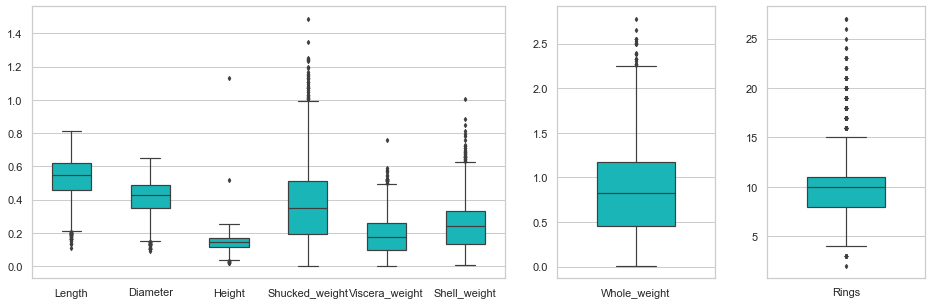

In [ ]:
fig2 = plt.figure(figsize=(16, 5))
gs2 = plt.GridSpec(1, 3, width_ratios=[3, 1, 1])

# Draw boxplots to show the outliers
for ind, col in enumerate((att_small_scale, att_large_scale, att_largest_scale)):
    _ = sns.boxplot(data=abalone_train_0[col], width=0.5, color='darkturquoise',
                    ax=fig2.add_subplot(gs2[ind]), linewidth=1.2, fliersize=3)

From boxplots, we can see more clearly the distribution of the values of each feature and target. This distribution is more or less close to normal. The points also show the values that were determined as outliers based on the interquartile range. Particularly noteworthy are the outliers in the "Height" column, since in most cases the height is less than the diameter and length. Perhaps these are errors or any deviations. In any case, there are few such values, so you can delete them.

In [ ]:
# Find the height values greater than the diameter or length values
abalone_train_0[(abalone_train_0.Height > abalone_train_0.Length)
                | (abalone_train_0.Height > abalone_train_0.Diameter)]

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
2051,F,0.455,0.355,1.13,0.594,0.332,0.116,0.1335,8


In [ ]:
abalone_train = abalone_train_0.drop(index=2051)

In [ ]:
# View the final value of the train dataset
abalone_train.shape

(3214, 9)

There are also outliers in the "Rings" column, and this will be our target for predicting, it is likely that these are just the ages for which there are simply few observations. We will look at the target in more detail.

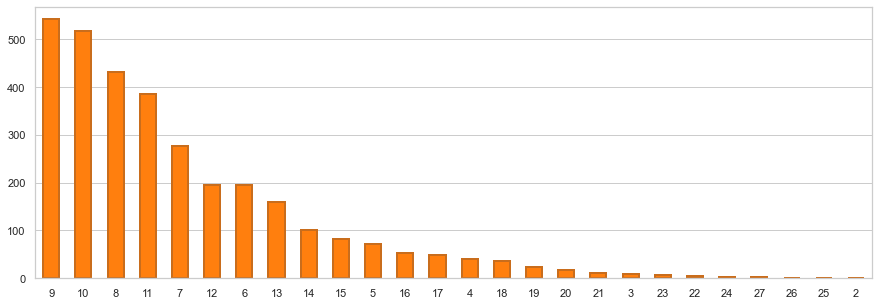

In [ ]:
fig3, axs3 = plt.subplots(figsize=(15, 5))

# Draw bars to show the frequency of the abalone by rings (ages)
abalone_train['Rings'].value_counts().plot.bar(ax=axs3, color='tab:orange',
                                               edgecolor='#c96d1c', linewidth=2, rot=0)
axs3.xaxis.grid(False)
plt.show()

In [ ]:
abalone_train.Rings.nunique()

26

As we can see, we have data on abalone aged from 2 to 27 years, with very little data on individuals whose age is more than 19 years and less than 4. Therefore, we can consider the age prediction problem as a regression problem (age does not have to be an integer) or as a multi-class classification problem, but the age boundaries will have to be combined into separate classes, for example, abalone with an age greater than or equal to 22 and less than or equal to 3.

### 2.3. Analysis of relationships between columns in the dataset

To identify the relationship between both the features and the features and the target, we will compute the correlation between them and build a heatmap and a pairplot. 

In [ ]:
# Compute pairwise correlation of columns
corr = abalone_train.corr()

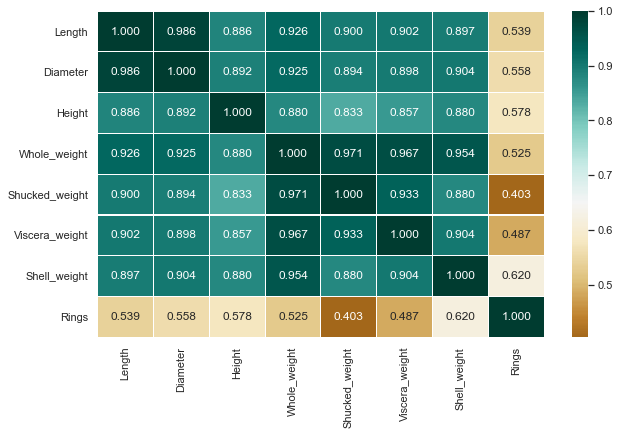

In [ ]:
plt.figure('heatmap', figsize=(10, 6))

# Draw a heatmap with the correlation values in each cell
_ = sns.heatmap(corr, annot=True, center=0.65,
                linewidths=0.05, cmap='BrBG', fmt='.3f')

All numeric feature columns have a strong linear correlation, while with the target they are linearly correlated weakly. This may cause some machine learning models to perform poorly due to the multicollinearity of the data. We can try to solve this problem by using dimension reduction tools or nonlinear feature transformation.

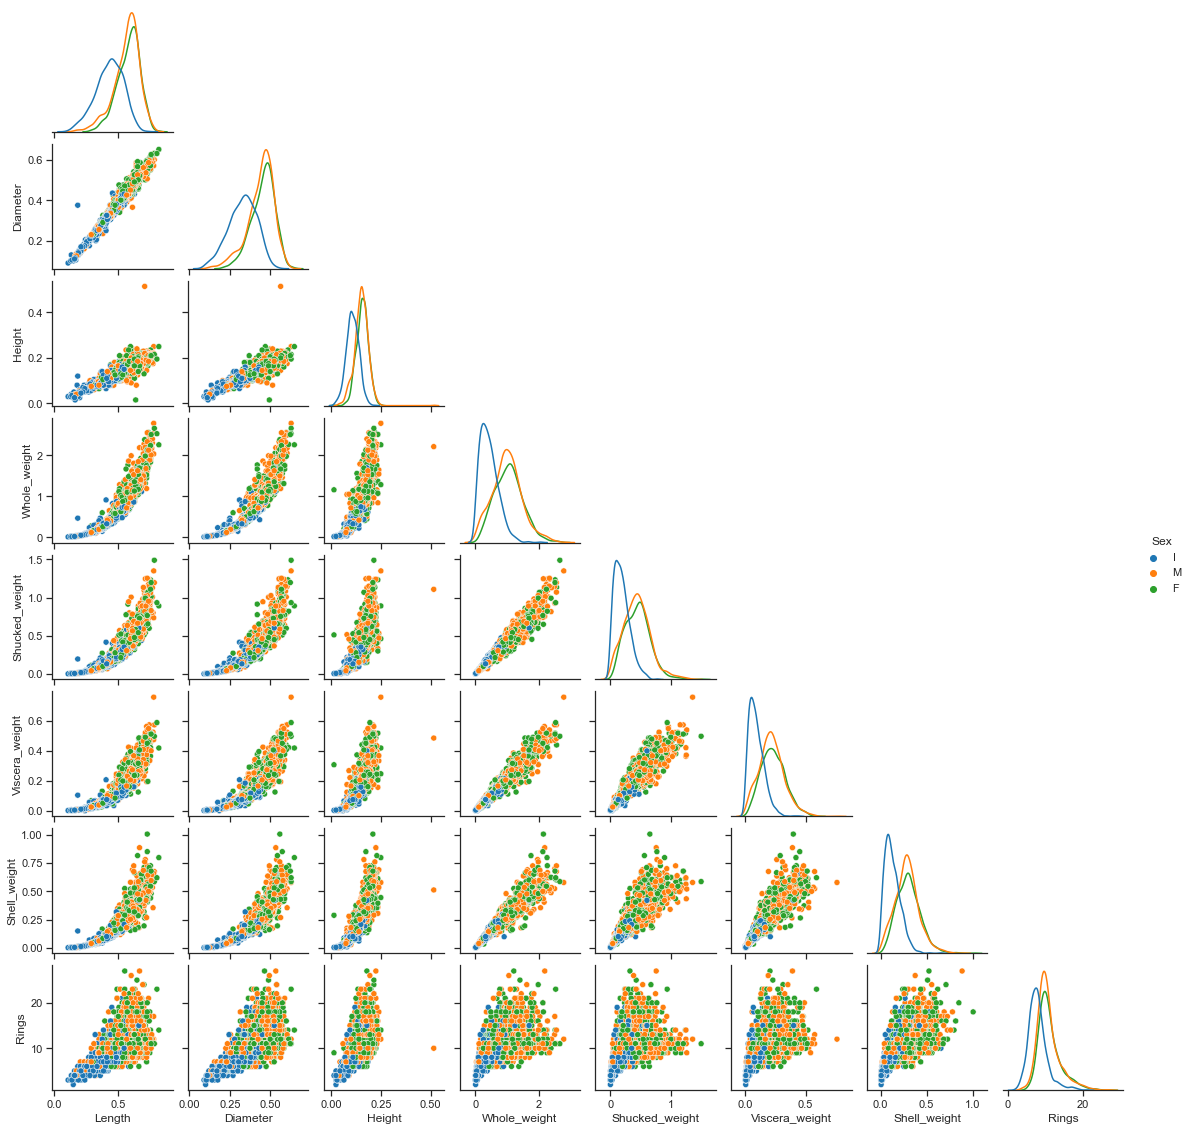

In [ ]:
# Draw pairplots to identify pairwise relationships in the dataset
with sns.axes_style('ticks'):
    _ = sns.pairplot(abalone_train, x_vars=num_cols, y_vars=num_cols,
                     kind='scatter', diag_kind='kde', hue='Sex', corner=True,
                     height=2, palette='tab10', diag_kws={'fill': False})

# Uncomment these lines of code to save plot without showing it
# plt.savefig("pairplot_abalone.pdf")
# plt.close()

These pairplots show that indeed the features have a linear relationship with each other, but for the target of this relationship is not so pronounced and it can most likely be described in a different way.

## 3. Data preparation

For further work, we will perform a preliminary data transformation, namely: 

1.   divide the dataset into the target and the features;
2.   convert categorical variables into indicator (one-hot numeric) variables;
3.   (only for the classification task) merge data on abalone aged 3 years or younger in the third class and aged 22 years and older in the 22nd class. 
4.    divide the data into a dataset for training models and their validation. For validation, we will take a small part, since we will select models using GridSearchCV, which itself uses cross-validation.


In [ ]:
# Divide a dataset into the features and the target
X = abalone_train.drop('Rings', axis=1)
y = abalone_train.Rings.astype('float64')

In [ ]:
num_train_cols = [col for col in X.select_dtypes(include='number').columns]

In [ ]:
# Encode categorical features
X_onehot = pd.get_dummies(X, columns=['Sex'], dtype=float)

In [ ]:
# Transform the target for the classification task
y_merge = y.mask(y <= 3, 3).mask(y >= 22, 22)

In [ ]:
# Count number of classes
print(y_merge.nunique())

20


In [ ]:
# Split the data for regression task
X_train, X_val, y_train, y_val = train_test_split(X_onehot, y, test_size=0.12, random_state=0)

In [ ]:
# Split the data for classification task
X_train_merge, X_val_merge, y_train_merge, y_val_merge = train_test_split(X_onehot, y_merge, test_size=0.12,
                                                                          stratify=y_merge, random_state=0)

We will select several scikit-learn tools for preprocessing features, as well as several dimensionality reduction tools. Our objective is not to test all of them, but to see how their use will affect the performance of machine learning models.

In [ ]:
# Create preprocessing instances
funct = FunctionTransformer(np.log1p)
stand = StandardScaler()
norm = Normalizer()
poly = PolynomialFeatures(interaction_only=True)
nyst = Nystroem()
addchi2 = AdditiveChi2Sampler()

In [ ]:
# Create dimensionality reduction instances
pca = PCA(n_components=4, random_state=0, whiten=True)
fica = FastICA(n_components=4, random_state=0, whiten=True)
fa = FactorAnalysis(n_components=4, random_state=0)

We have set the initial parameters to those that we think should show the best results according to the documentation.

In [ ]:
preprocs = ['passthrough', funct, stand, norm, poly, nyst, addchi2]
dim_reds = [None, pca, fica, fa]

## 4. Selecting models

To solve the problem of predicting the age of abalone by its characteristics, we will use scikit-learn tools for both regression and classification, and at the end we will compare the results. We will not test all possible models, but simply select one or two models of each type and see how well they work. And then we will choose the best ones for each task. 

To begin with, we will define the necessary functions: for convenient representation of the obtained data and visualization of predictions. And also define the template of the pipeline used.

In [ ]:
def convert_gscv_results_todf(gscv, key_cv_results, name_columns=None):
    """Converts the results of GridSearchCV to a pd.DataFrame with the specified names of columns.

    Parameters:
    ------------
    gscv -- fitted GridSearchCV instance 
    key_cv_results -- list of keys of cv_results_
    name_columns -- column names for a resulting DataFrame
    """
    dfs = []
    for idx, cvr in enumerate(key_cv_results):
        if cvr == 'params':
            param_df = pd.DataFrame(gscv.cv_results_['params'])
            dfs.append(param_df)
        else:
            res_df = pd.DataFrame({cvr.title(): gscv.cv_results_[cvr]})
            dfs.append(res_df)

    join_df = dfs[0]
    for df in dfs[1:]:
        join_df = join_df.join(df)

    join_df.columns = name_columns

    return join_df

In [ ]:
def plot_pipe_preds(y_true, y_pred, *, title, colors=['darkslategrey', 'lightcoral'], **kwargs):
    """Draw scatter plots of true targets and pipeline predicted vs true targets on a single ax.

    Parameters:
    ----------
    **kwargs -- shared kwargs for two plots
    """
    fig, ax = plt.subplots()
    y_true_name = y_true.name
    y_pred_name = ''.join([y_true_name, '_pred'])

    for y, color in zip([y_true, y_pred], colors):
        ax.scatter(x=y_true, y=y, c=color, **kwargs)

    ax.set_title(title, fontsize=10)
    ax.set_xlabel(y_true_name)
    ax.set_ylabel(y_pred_name)
    ax.grid(True, alpha=0.5)
    plt.show()

In [ ]:
# Create the base pipeline
base_pipe = Pipeline([('preprocessor', ColumnTransformer([('transform', 'passthrough', num_train_cols)],
                                                         remainder='passthrough')),
                      ('dim_reduction', None), ('model', None)])

### 4.1. Regression

For the regression task, we will use mean_absolute_error so it is easier to interpret and the base score will be obtained from DummyRegressor.

In [ ]:
dummy_reg = DummyRegressor(strategy='median')

linreg = LinearRegression()
kridge = KernelRidge()
kneighreg = KNeighborsRegressor()
dtreereg = DecisionTreeRegressor(max_depth=3, random_state=0)
svr = SVR()
nusvr = NuSVR()
gausreg = GaussianProcessRegressor(random_state=0)
gbreg = GradientBoostingRegressor(random_state=0)

xgb_reg = xgb.XGBRegressor()
lgb_reg = lgb.LGBMRegressor(random_state=0)

In [ ]:
reg_models = [linreg, kridge, kneighreg, dtreereg, svr, 
              nusvr, gausreg, gbreg, xgb_reg, lgb_reg]

In [ ]:
# Compute the base score
dummy_reg_pred = dummy_reg.fit(X_train, y_train).predict(X_val)
mean_absolute_error(y_val, dummy_reg_pred)

2.326424870466321

In [ ]:
# Evaluate the various pipeline params and select the best from them and score values
reg_pipe_params = {'preprocessor__transform': preprocs,
                   'dim_reduction': dim_reds,
                   'model': reg_models}

gscv_reg = GridSearchCV(base_pipe, reg_pipe_params,
                        scoring='neg_mean_absolute_error', cv=3).fit(X_train, y_train)
print(gscv_reg.best_params_)
print(-1 * gscv_reg.best_score_)

{'dim_reduction': PCA(n_components=4, random_state=0, whiten=True), 'model': SVR(), 'preprocessor__transform': Normalizer()}
1.4641702884066843


We can see that the best score is obtained when we use both preprocessing and dimensionality reduction tools. Next, we will look at how the score values and the list of best models changed when adding these steps. The best model was the svm-based one.

In [ ]:
df_reg_columns = ['Dim_reduction', 'Model', 'Preprocessor', 'MAE', 'Fit_time']
gscv_reg_df_neg = convert_gscv_results_todf(
    gscv_reg, ['params', 'mean_test_score', 'mean_fit_time'], df_reg_columns)
gscv_reg_df = gscv_reg_df_neg.assign(MAE=-1 * gscv_reg_df_neg.MAE)

# Uncomment this this line of code to save the result
# gscv_reg_df.to_csv("The regression cv_results", index=False)

In [ ]:
# View results without features transformations
(gscv_reg_df.loc[(gscv_reg_df.Preprocessor == 'passthrough') & gscv_reg_df.Dim_reduction.isnull(),
                 ['Model', 'MAE', 'Fit_time']].sort_values('MAE'))

,Model,MAE,Fit_time
49,GradientBoostingRegressor(random_state=0),1.548178,0.567282
63,LGBMRegressor(random_state=0),1.568697,0.235681
28,SVR(),1.580186,0.456666
0,LinearRegression(),1.588479,0.016261
35,NuSVR(),1.591174,0.383485
7,KernelRidge(),1.594040,0.293129
14,KNeighborsRegressor(),1.599441,0.016418
56,"XGBRegressor(base_score=None, booster=None, co...",1.644205,0.519274
21,"DecisionTreeRegressor(max_depth=3, random_stat...",1.793248,0.018181
42,GaussianProcessRegressor(random_state=0),8.403889,0.738726


As we can see, almost all models worked the same way, with the exception of the GaussianProcessRegressor model, which performs worse than the DummyRegressor.

In [ ]:
# View results with preprocessing only
gscv_reg_df.loc[gscv_reg_df.Dim_reduction.isnull(),
                ['Model', 'Preprocessor', 'MAE', 'Fit_time']].nsmallest(10, 'MAE')

,Model,Preprocessor,MAE,Fit_time
30,SVR(),StandardScaler(),1.497553,0.550201
37,NuSVR(),StandardScaler(),1.507902,0.357128
54,GradientBoostingRegressor(random_state=0),Nystroem(),1.521527,9.982980
6,LinearRegression(),AdditiveChi2Sampler(),1.524906,0.021214
3,LinearRegression(),Normalizer(),1.526742,0.021226
52,GradientBoostingRegressor(random_state=0),Normalizer(),1.527544,0.795940
4,LinearRegression(),PolynomialFeatures(interaction_only=True),1.533823,0.031993
13,KernelRidge(),AdditiveChi2Sampler(),1.547525,0.284988
50,GradientBoostingRegressor(random_state=0),FunctionTransformer(func=<ufunc 'log1p'>),1.548068,0.570086
49,GradientBoostingRegressor(random_state=0),passthrough,1.548178,0.567282


If the features are further normalized, scaled, or otherwise transformed, the scores will generally improve, but the effect will be different for different models. For example, if we combine the Nystroem kernel approximation and the GradientBoostingRegressor model, the score will improve by about 0.03, but the fitting time will increase by more than 17 times.

In [ ]:
# View results with dimensionality reduction only
gscv_reg_df.loc[gscv_reg_df.Preprocessor == 'passthrough',
                ['Model', 'Dim_reduction', 'MAE', 'Fit_time']].nsmallest(10, 'MAE')

,Model,Dim_reduction,MAE,Fit_time
168,SVR(),"FastICA(n_components=4, random_state=0)",1.485105,0.338485
98,SVR(),"PCA(n_components=4, random_state=0, whiten=True)",1.485105,0.380123
175,NuSVR(),"FastICA(n_components=4, random_state=0)",1.491203,0.286387
105,NuSVR(),"PCA(n_components=4, random_state=0, whiten=True)",1.491203,0.269995
182,GaussianProcessRegressor(random_state=0),"FastICA(n_components=4, random_state=0)",1.527841,0.432196
119,GradientBoostingRegressor(random_state=0),"PCA(n_components=4, random_state=0, whiten=True)",1.543452,0.322836
49,GradientBoostingRegressor(random_state=0),None,1.548178,0.567282
189,GradientBoostingRegressor(random_state=0),"FastICA(n_components=4, random_state=0)",1.553198,0.340238
63,LGBMRegressor(random_state=0),None,1.568697,0.235681
28,SVR(),None,1.580186,0.456666


Using only dimensionality reduction before training more than 5.5 times improved the results of the GaussianProcessRegressor model, but some models, such as LGBMRegressor, began to make predictions worse. 

In [ ]:
# View the results as a whole
gscv_reg_df.loc[:, ['Model', 'Preprocessor',
                    'Dim_reduction', 'MAE', 'Fit_time']].nsmallest(10, 'MAE')

,Model,Preprocessor,Dim_reduction,MAE,Fit_time
101,SVR(),Normalizer(),"PCA(n_components=4, random_state=0, whiten=True)",1.464170,0.349831
171,SVR(),Normalizer(),"FastICA(n_components=4, random_state=0)",1.464170,0.343671
99,SVR(),FunctionTransformer(func=<ufunc 'log1p'>),"PCA(n_components=4, random_state=0, whiten=True)",1.471802,0.357793
169,SVR(),FunctionTransformer(func=<ufunc 'log1p'>),"FastICA(n_components=4, random_state=0)",1.471802,0.338452
108,NuSVR(),Normalizer(),"PCA(n_components=4, random_state=0, whiten=True)",1.471947,0.260318
178,NuSVR(),Normalizer(),"FastICA(n_components=4, random_state=0)",1.471947,0.286390
176,NuSVR(),FunctionTransformer(func=<ufunc 'log1p'>),"FastICA(n_components=4, random_state=0)",1.478924,0.265587
106,NuSVR(),FunctionTransformer(func=<ufunc 'log1p'>),"PCA(n_components=4, random_state=0, whiten=True)",1.478924,0.281212
168,SVR(),passthrough,"FastICA(n_components=4, random_state=0)",1.485105,0.338485
98,SVR(),passthrough,"PCA(n_components=4, random_state=0, whiten=True)",1.485105,0.380123


The best models for this dataset turned out to be based on svm. In this case, reducing the dimension of PCA or FastICA gives the same score values, but the fitting time is slightly different. As a result, using the preprocessing and dimensionality reduction tools together gives a better score than not using them or using them separately.

We will create a pipeline from the best parameters that we found so that we can further improve it.

In [ ]:
best_pipe_reg = Pipeline([('preprocessor', ColumnTransformer([('transform', Normalizer(),
                                                               num_train_cols)], remainder='passthrough')),
                          ('dim_reduction', PCA(n_components=4, random_state=0, whiten=True)), ('model', SVR())])

MAE:  1.4193022863433011


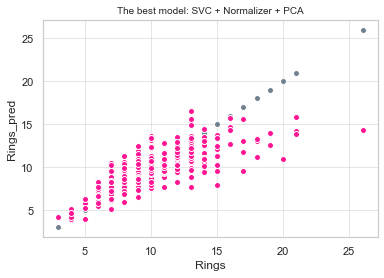

In [ ]:
# Plot the best pipeline
pipe_reg_preds = best_pipe_reg.fit(X_train, y_train).predict(X_val)
print("MAE: ", mean_absolute_error(y_val, pipe_reg_preds))
rtitle = "The best model: SVC + Normalizer + PCA"
plot_pipe_preds(y_val, pipe_reg_preds, title=rtitle, colors=['slategrey', 'deeppink'],
                edgecolors='w', linewidths=1)

Now we will try to improve our best pipeline by changing the values of hyperparameters and see how the training and testing score changes when the number of PCA components changes.

In [ ]:
# Search for the best hyperparameters
reg_param_grid_best = {'model__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                       'preprocessor__transform__norm': ['l1', 'l2', 'max']}

reg_gscv_best = GridSearchCV(best_pipe_reg, reg_param_grid_best,
                             scoring='neg_mean_absolute_error').fit(X_train, y_train)
print(reg_gscv_best.best_params_)
print(-1 * reg_gscv_best.best_score_)

{'model__kernel': 'rbf', 'preprocessor__transform__norm': 'l2'}
1.4635182051935804


The best hyperparameters turned out to be the ones we initially set.

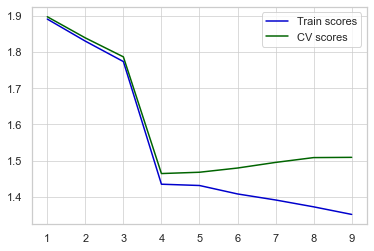

In [ ]:
reg_param_range = range(1, 10)
train_scores, cv_scores = validation_curve(estimator=best_pipe_reg, X=X_train, y=y_train,
                                           param_name='dim_reduction__n_components',
                                           param_range=reg_param_range,
                                           scoring='neg_mean_absolute_error', cv=3)
train_scores_mean = -1 * train_scores.mean(axis=1)
cv_scores_mean = -1 * cv_scores.mean(axis=1)
plt.plot(reg_param_range, train_scores_mean,
         label="Train scores", color='mediumblue')
plt.plot(reg_param_range, cv_scores_mean, label="CV scores", color='darkgreen')
plt.grid(True, alpha=0.7)
plt.legend()
plt.show()

The plots show that the projection of features on the 4th dimension gives a significant decrease in the prediction error, but starting from the 5th component, overfitting begins. In our case, the selected number of components was also the best.

### 4.2. Classification

To find the best classification model for the dataset we are considering, we will perform the same steps as for regression. At the same time, we also do not have the task of checking all existing scikit-learn models. As a metric, we will choose an F1 score with a weighted average, because we have 20 classes and they are unbalanced.

In [ ]:
dummy_class = DummyClassifier(strategy='stratified', random_state=0)

log_reg = LogisticRegression(multi_class='multinomial', 
                             max_iter=500, random_state=0)
svc = SVC()
gaus_class = GaussianProcessClassifier(multi_class='one_vs_one', random_state=0)
kneigh_class = KNeighborsClassifier()
dtree_class = DecisionTreeClassifier(max_depth=3, random_state=0)
gaus_nb = GaussianNB()
lda = LinearDiscriminantAnalysis()
randforest_class = RandomForestClassifier(random_state=0)

lgb_class = lgb.LGBMClassifier(objective='multiclass', random_state=0)

In [ ]:
class_models = [log_reg, svc, dtree_class, gaus_class, kneigh_class,
                gaus_nb, lda, randforest_class, lgb_class]

In [ ]:
# Compute the base score
dummy_class_pred = dummy_class.fit(X_train_merge, y_train_merge).predict(X_val_merge)
f1_score(y_val_merge, dummy_class_pred, average='weighted')

0.14892832230853334

In [ ]:
# Evaluate the various pipeline params and select the best from them and score values
class_pipe_params = {'preprocessor__transform': preprocs,
                     'dim_reduction': dim_reds,
                     'model': class_models}

gscv_class = GridSearchCV(base_pipe, class_pipe_params,
                          scoring='f1_weighted', cv=3).fit(X_train_merge, y_train_merge)
print(gscv_class.best_params_)
print(gscv_class.best_score_)

{'dim_reduction': None, 'model': LinearDiscriminantAnalysis(), 'preprocessor__transform': AdditiveChi2Sampler()}
0.2617428412007936


The best was a pipeline using approximate explicit feature maps and without the dimensionality reduction step, but we will also look at other pipeline options.

In [ ]:
df_class_columns = ['Dim_reduction', 'Model',
                    'Preprocessor', 'F1_weight', 'Fit_time']
gscv_class_df = convert_gscv_results_todf(
    gscv_class, ['params', 'mean_test_score', 'mean_fit_time'], df_class_columns)

# Uncomment this this line of code to save the result
# gscv_class_df.to_csv("The classification cv_results", index=False)

In [ ]:
# View results without features transformations
(gscv_class_df.loc[(gscv_class_df.Preprocessor == 'passthrough') & gscv_class_df.Dim_reduction.isnull(),
                   ['Model', 'F1_weight', 'Fit_time']].sort_values('F1_weight', ascending=False))

,Model,F1_weight,Fit_time
42,LinearDiscriminantAnalysis(),0.241912,0.015614
49,RandomForestClassifier(random_state=0),0.236609,0.656097
56,"LGBMClassifier(objective='multiclass', random_...",0.231419,2.744128
28,KNeighborsClassifier(),0.221812,0.010420
21,GaussianProcessClassifier(multi_class='one_vs_...,0.219340,5.594290
7,SVC(),0.211234,0.364491
0,"LogisticRegression(max_iter=500, multi_class='...",0.207684,0.381808
14,"DecisionTreeClassifier(max_depth=3, random_sta...",0.177201,0.010415
35,GaussianNB(),0.087471,0.010415


In general, the values of the scores of all the selected classifiers, without any feature transformations, are close to each other, with the exception of the GaussianNB, which performs worse than the DummyClassifier. But the fitting time is significantly different. It should also be noted that the best model, in this case, is LinearDiscriminantAnalysis.

In [ ]:
# View results with preprocessing only
(gscv_class_df.loc[gscv_class_df.Dim_reduction.isnull(), 
                   ['Model', 'Preprocessor', 'F1_weight', 'Fit_time']].nlargest(10, 'F1_weight'))

,Model,Preprocessor,F1_weight,Fit_time
48,LinearDiscriminantAnalysis(),AdditiveChi2Sampler(),0.261743,0.020822
47,LinearDiscriminantAnalysis(),Nystroem(),0.257119,0.052086
45,LinearDiscriminantAnalysis(),Normalizer(),0.248994,0.005208
46,LinearDiscriminantAnalysis(),PolynomialFeatures(interaction_only=True),0.246736,0.020830
23,GaussianProcessClassifier(multi_class='one_vs_...,StandardScaler(),0.244809,5.420532
43,LinearDiscriminantAnalysis(),FunctionTransformer(func=<ufunc 'log1p'>),0.243432,0.010413
42,LinearDiscriminantAnalysis(),passthrough,0.241912,0.015614
44,LinearDiscriminantAnalysis(),StandardScaler(),0.241912,0.015621
54,RandomForestClassifier(random_state=0),Nystroem(),0.241651,2.391748
50,RandomForestClassifier(random_state=0),FunctionTransformer(func=<ufunc 'log1p'>),0.238398,0.649988


If we perform a feature transformation, such as scaling, before using the classifier, then some models will produce better results, for example, GaussianProcessClassifier.

In [ ]:
# View results with dimensionality reduction only
(gscv_class_df.loc[gscv_class_df.Preprocessor == 'passthrough',
                   ['Model', 'Dim_reduction', 'F1_weight', 'Fit_time']].nlargest(10, 'F1_weight'))

,Model,Dim_reduction,F1_weight,Fit_time
84,GaussianProcessClassifier(multi_class='one_vs_...,"PCA(n_components=4, random_state=0, whiten=True)",0.255696,5.220528
42,LinearDiscriminantAnalysis(),None,0.241912,0.015614
70,SVC(),"PCA(n_components=4, random_state=0, whiten=True)",0.237234,0.385352
133,SVC(),"FastICA(n_components=4, random_state=0)",0.237234,0.496178
49,RandomForestClassifier(random_state=0),None,0.236609,0.656097
56,"LGBMClassifier(objective='multiclass', random_...",None,0.231419,2.744128
63,"LogisticRegression(max_iter=500, multi_class='...","PCA(n_components=4, random_state=0, whiten=True)",0.230951,0.218698
105,LinearDiscriminantAnalysis(),"PCA(n_components=4, random_state=0, whiten=True)",0.227034,0.000000
168,LinearDiscriminantAnalysis(),"FastICA(n_components=4, random_state=0)",0.227034,0.020827
28,KNeighborsClassifier(),None,0.221812,0.010420


The use of dimensionality reduction tools affects those models that use the kernel parameter.

In [ ]:
# View the results as a whole
gscv_class_df.loc[:, ['Model', 'Preprocessor', 'Dim_reduction',
                      'F1_weight', 'Fit_time']].nlargest(10, 'F1_weight')

,Model,Preprocessor,Dim_reduction,F1_weight,Fit_time
48,LinearDiscriminantAnalysis(),AdditiveChi2Sampler(),None,0.261743,0.020822
47,LinearDiscriminantAnalysis(),Nystroem(),None,0.257119,0.052086
85,GaussianProcessClassifier(multi_class='one_vs_...,FunctionTransformer(func=<ufunc 'log1p'>),"PCA(n_components=4, random_state=0, whiten=True)",0.256035,5.388036
214,GaussianProcessClassifier(multi_class='one_vs_...,PolynomialFeatures(interaction_only=True),FactorAnalysis(n_components=4),0.255708,5.881133
84,GaussianProcessClassifier(multi_class='one_vs_...,passthrough,"PCA(n_components=4, random_state=0, whiten=True)",0.255696,5.220528
87,GaussianProcessClassifier(multi_class='one_vs_...,Normalizer(),"PCA(n_components=4, random_state=0, whiten=True)",0.254348,5.226065
237,LinearDiscriminantAnalysis(),AdditiveChi2Sampler(),FactorAnalysis(n_components=4),0.252610,1.405707
194,"LogisticRegression(max_iter=500, multi_class='...",Nystroem(),FactorAnalysis(n_components=4),0.249650,0.515501
45,LinearDiscriminantAnalysis(),Normalizer(),None,0.248994,0.005208
236,LinearDiscriminantAnalysis(),Nystroem(),FactorAnalysis(n_components=4),0.246752,0.270614


As we can see, the LinearDiscriminantAnalysis classifiers are among the first ones, and they are also fast.

In [ ]:
best_pipe_class = Pipeline([('preprocessor', ColumnTransformer([('transform', AdditiveChi2Sampler(),
                                                                 num_train_cols)], remainder='passthrough')),
                            ('model', LinearDiscriminantAnalysis())])

F1_weighted:  0.2608745100853136


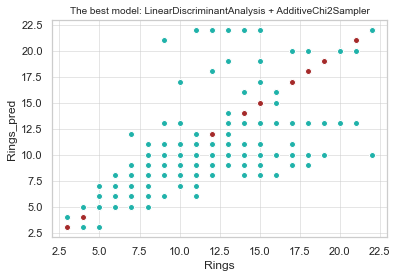

In [ ]:
# Plot the best pipeline
pipe_class_preds = best_pipe_class.fit(
    X_train_merge, y_train_merge).predict(X_val_merge)
print("F1_weighted: ", f1_score(y_val_merge, pipe_class_preds, average='weighted'))
ctitle = "The best model: LinearDiscriminantAnalysis + AdditiveChi2Sampler"
plot_pipe_preds(y_val_merge, pipe_class_preds, title=ctitle, colors=['brown', 'lightseagreen'],
                edgecolors='w', linewidths=1)

## 5. Testing the best models

At the end, we will evaluate the best regression and classification pipelines on test data that our models have not yet seen.

In [ ]:
# Prepare data for testing
X_test = pd.get_dummies(abalone_test_all.drop('Rings', axis=1), 
                        columns=['Sex'], dtype=float)
y_test = abalone_test_all.Rings.astype('float64')
y_test_merge = y_test.mask(y_test <= 3, 3).mask(y_test >= 24, 24)

In [ ]:
# Evaluate the best regression pipeline
reg_test_preds = best_pipe_reg.predict(X_test)
print("Test MAE: ", mean_absolute_error(y_test, reg_test_preds))

Test MAE:  1.4628107409846518


In [ ]:
# Evaluate the best classification pipeline
class_test_preds = best_pipe_class.predict(X_test)
print("Test f1_weighted: ", f1_score(y_test_merge,
                                     class_test_preds, average='weighted'))

Test f1_weighted:  0.267332207236063


As we can see, we got score values very close to what we computed earlier, which means that our best pipelines predict well. We can also compute mean_absolute_error for the classification task to determine how much the values predicted by the classifier differ from the true values, since we have a multi-class problem and the class values are integers.

In [ ]:
print("Test MAE: ", mean_absolute_error(y_test, class_test_preds))

Test MAE:  1.5406698564593302


It turns out that the best regression pipeline gives predictions with an error of approximately +/- 1.46, and the classification one with an error of approximately +/- 1.54. At the same time, the second one works more than 15 times faster, although some of the classes were merged because there were not enough samples for some of them. Therefore, we can use both regression models and classifiers for this dataset.